## IBM Data Science Capstone Jupyter Notebook #2:
### Data Preparation, Modeling and Evaluation
__Author: Sam Steffes__
<br>*Date: 08/27/2020*

This notebook contains code for part 2 of my Coursera IBM Data Science Capstone project. This project uses data from previous vehicle collisions to try and build a machine learning model that predicts the severity of accidents based on certain features. __This notebook will focus on data cleansing and preparation, model training and model evaluation.__

Here is a link to notebook #1, which included examination and exploratory analysis of the dataset:


_The data comes from collision records recorded by the Seattle Police Department from 2004 through May of 2020_

In [1]:
#import required libraries for handling and visualizing data
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#more libraries from the sklearn package will be imported later for modeling and evaluation

In [2]:
#import the relevant datasets

#the initial SDOT dataset on collisions between 2004 and 2020
df_csv = pd.read_csv('Data-collisions.csv')

#at the end of the first notebook we exported a slightly modified dataframe of the 12 features that were initially
#identified as possible model features... lets import that and pick up our data cleaning efforts there...
df_exp = pd.read_csv('explored_features.csv')
df_exp['DATETIME']=df_exp['DATETIME'].astype('datetime64[ns]')
df_exp.head()

c:\python\python384\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DATETIME,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,SEVERITYCODE
0,2013-03-27 14:54:00,Angles,2,0,0,2,N,N,Overcast,Wet,Daylight,N,2
1,2006-12-20 18:55:00,Sideswipe,2,0,0,2,N,0,Raining,Wet,Dark - Street Lights On,N,1
2,2004-11-18 10:20:00,Parked Car,4,0,0,3,N,0,Overcast,Dry,Daylight,N,1
3,2013-03-29 09:26:00,Other,3,0,0,3,N,N,Clear,Dry,Daylight,N,1
4,2004-01-28 08:04:00,Angles,2,0,0,2,N,0,Raining,Wet,Daylight,N,2


### 2.0 Feature selection:

Let's revisit the 12 features that were initially identified as possible features, summarize the findings and declare whether they will be used in the model.

|Column Name|Description|Findings|Included & How|
|:---|:---|:---|:---|
|COLLISIONTYPE|A keyword describing the collision, eg 'head-on', 'angled', 'cycles', etc.|There are differences in the injury rate between different types of collisions, including significant increases for Pedestrian and Cycle types.|**Yes**: Collision type will be included using one-hot encoding.|
|PERSONCOUNT|Total number of people involved in the collision. |The proportion of injury collisions is higher when there are >3 people involved. May indicate more cars which could be more severe incidents, or more people in the vehicles, seated in locations that absorbed more force.|**Yes**: a simplified one-hot feature identifying if there are fewer (0) or 3 or more (1) people involved.|
|PEDCOUNT|The number of pedestrians involved in the collision.|Injuries occur much more frequently when there are 1 or more pedestrians involved. However, this relationship is already captured by the 'Pedestrian' collision type.|*No*: This would make a redundant feature and does not need to be included.|
|PEDCYLCOUNT|The number of bicycles involved.|Injuries occur much more frequently where bicycles are involved. However, again this is captured by the collision type impact.|*No*: This would be redundant.|
|VEHCOUNT|The number of vehicles involved in the collision.|Countplot shows that a higher portion of collisions involving something other than 2 cars result in injury. Further analysis showed that many collisions for 1 vehicle involve pedestrians or bikes, so the higher injury rate makes sense. Collisions involving 3 or more cars may have been more dangerous or severe, and also include more opportunities for injury.|**Yes**: a simplified one-hot feature identifying the number of vehicles as 2 (1) or not (0).|
|INCDATE/INCDTTM|Date and time recordings for the incident records.|The volume of total collisions and rate of injury collisions does not fluctuate much for the different days of the week, however, there are clear peaks in the rate of injury collisions during the typical rushhour periods.|**Yes**: datetime value will be used to create a one-hot encoding feature that captures whether the collision occured during rushhour (1) or not (0).|
|INATTENTIONIND|If collision was due to inattention.|There is a slightly higher rate of injury collisions among samples where inattentive driving was identified.|**Yes**:this is already a Y/N feature, which can be converted to 0,1 coding.|
|UNDERINFL|If driver was under influence of drugs/alchohol.|There is a higher rate of injury collisions among samples where drugs or alcohol were involved.|**Yes**:this is a Y/N feature which will be converted to 0,1 coding. Some cleansing will be required since currently both Y/N and 0/1 formats are used. Also, there are ~5000 blank records that can be dropped.|
|WEATHER|Weather at the time of incident.|More severe weather conditions did not show injury rates out of proportion with the total population.|*No*|
|ROADCOND|Condition of road at the time of incident.|More dangerous or road conditions did not show injury rates significantly out of proportion with the total population.|*No*|
|LIGHTCOND|Light conditions at the time of incident.|The proportion of injury collisions did not stand out for any of the different lighting categories with meaningful volume.|*No*|
|SPEEDING|If speeding was a factor in the collision.|The proportion of injury collisions was 1.28 times higher when speeding was involved.|**Yes**:this is a Y/N feature which will be converted to 0,1 coding.|

Some highlights/examples of the exploratory analysis that was performed are repeated below. For the full notebook, visit here:


Count of total collisions:  194673
Count of collisions on weekdays:  145329
Count of collisions on weekends:  49344


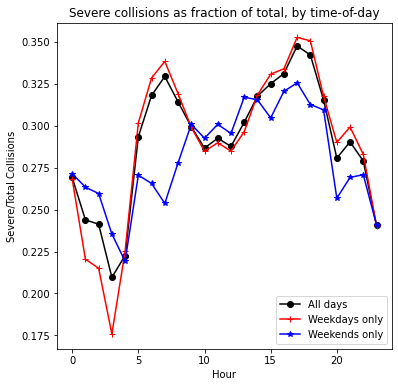

In [3]:
#exploration of injury collision rates for different times of the day

#generate df grouped by hour of day and severity code, for all days of the week
df_hour = df_exp.groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour.reset_index(drop=False,inplace=True)
df_hour.columns = ['Hour','Property','Injury']
df_hour['Total'] = df_hour['Property'] + df_hour['Injury']
df_hour['inj_rate'] = df_hour['Injury'] / df_hour['Total']

#generate an identical grouped dataframe, but including only weekdays - want to see if rush-hour impact stands out more
wkdays = [0,1,2,3,4] #list of values that correspond to Monday-Friday
df_hour2 = df_exp[df_exp.DATETIME.dt.dayofweek.isin(wkdays)].groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour2.reset_index(drop=False,inplace=True)
df_hour2.columns = ['Hour','Property','Injury']
df_hour2['Total'] = df_hour2['Property'] + df_hour2['Injury']
df_hour2['inj_rate'] = df_hour2['Injury'] / df_hour2['Total']

#generate a third df for only weekend days
df_hour3 = df_exp[~df_exp.DATETIME.dt.dayofweek.isin(wkdays)].groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour3.reset_index(drop=False,inplace=True)
df_hour3.columns = ['Hour','Property','Injury']
df_hour3['Total'] = df_hour3['Property'] + df_hour3['Injury']
df_hour3['inj_rate'] = df_hour3['Injury'] / df_hour3['Total']

#print some relevant counts
print('Count of total collisions: ', df_hour['Total'].sum())
print('Count of collisions on weekdays: ', df_hour2['Total'].sum())
print('Count of collisions on weekends: ', df_hour['Total'].sum() - df_hour2['Total'].sum())

#generate a plot to compare the change in proportion of injury collisions by hour of the day
plt.figure(figsize=(6,6))
plt.plot('Hour','inj_rate',data=df_hour,marker='o',color='k')
plt.plot('Hour','inj_rate',data=df_hour2,marker='+',color='r')
plt.plot('Hour','inj_rate',data=df_hour3,marker='*',color='b')
plt.title('Severe collisions as fraction of total, by time-of-day')
plt.xlabel('Hour')
plt.ylabel('Severe/Total Collisions')
plt.legend(['All days','Weekdays only','Weekends only'],loc=4)
plt.show()

Text(0, 0.5, 'Severe/Total Collisions')

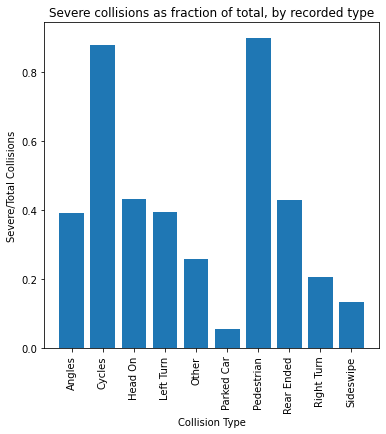

In [4]:
#exploration of injury collision rates for different collision types
df_type = df_exp.groupby(['COLLISIONTYPE','SEVERITYCODE']).size().unstack(fill_value=0)
df_type.reset_index(drop=False,inplace=True)
df_type.columns = ['Type','Property','Injury']
df_type['Total'] = df_type['Property'] + df_type['Injury']
df_type['inj_rate'] = df_type['Injury'] / df_type['Total']

plt.figure(figsize=(6,6))
plt.bar(df_type['Type'],df_type['inj_rate'])
plt.title('Severe collisions as fraction of total, by recorded type')
plt.xlabel('Collision Type')
plt.xticks(rotation=90)
plt.ylabel('Severe/Total Collisions')

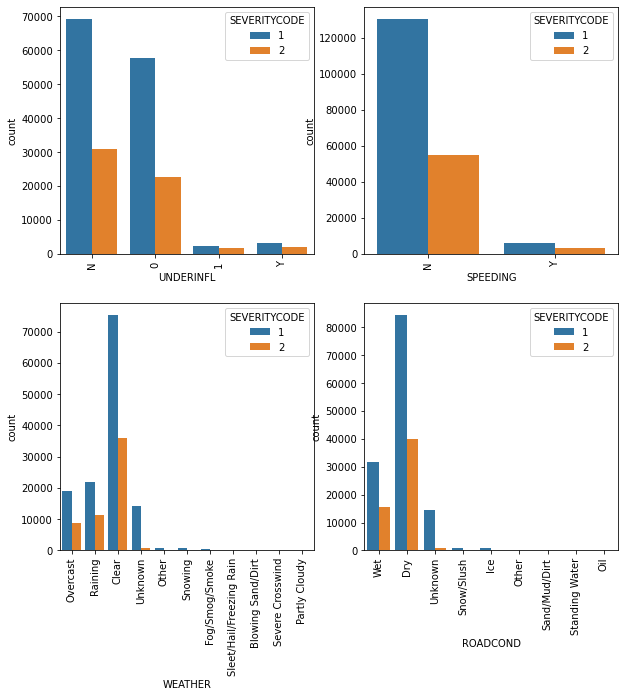

In [5]:
#visualization of the distribution of injury & property type collisions for different characteristics
#including, influence, speeding, weather and road condition
fig, ax = plt.subplots(2,2, figsize=(10,10))

sns.countplot(x='UNDERINFL',hue='SEVERITYCODE',data=df_exp, ax=ax[0,0])
sns.countplot(x='SPEEDING',hue='SEVERITYCODE',data=df_exp,ax=ax[0,1])
sns.countplot(x='WEATHER',hue='SEVERITYCODE',data=df_exp,ax=ax[1,0])
sns.countplot(x='ROADCOND',hue='SEVERITYCODE',data=df_exp,ax=ax[1,1])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

### 3.0 Data Cleansing and Preparation

Based on the feature selection table above, the following data cleansing and prep will be completed:

 - drop PEDCOUNT column
 - drop PEDCYLCOUNT column
 - drop WEATHER column
 - drop ROADCOND column
 - drop LIGHTCOND column
 - drop rows where COLLISIONTYPE, INATTENTIONIND, UNDERINFL or SPEEDING are blank
 - drop rows where PERSONCOUNT is 0
 - drop rows where the timestamp is 00:00:00 (these samples were missing a time value in the original INCDTTM column before converting to the datetime format). These likely don't have the correct time, and could incorrectly influence the model, which takes into account whether the incident occured during a rushhour period or not. All of these incidents would be categorized as non-rushhour, which may not be accurate.
 <br><br>
 - create column to identify if time is during either rushhour (5-8 or 15-18), then drop DATETIME
 - create column to identify if PERSONCOUNT is >=3, then drop PERSONCOUNT
 - create column to identify if VEHCOUNT is 2 or not, then drop VEHCOUNT
 - for INATTENTIONIND, convert N to 0 and Y to 1
 - for UNDERINFL, convert N to 0 and Y to 1
 - for SPEEDING, convert N to 0 and Y to 1
 - transform COLLISION type to one-hot encoding using get_dummies

In [6]:
#start data cleansing by dropping the desired columns... do this by creating a new dataframe with only the desired columns
df = df_exp[['DATETIME', 'COLLISIONTYPE','PERSONCOUNT','VEHCOUNT','INATTENTIONIND','UNDERINFL','SPEEDING','SEVERITYCODE']].copy()
print(df.shape)
df.head()

(194673, 8)


,DATETIME,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE
0,2013-03-27 14:54:00,Angles,2,2,N,N,N,2
1,2006-12-20 18:55:00,Sideswipe,2,2,N,0,N,1
2,2004-11-18 10:20:00,Parked Car,4,3,N,0,N,1
3,2013-03-29 09:26:00,Other,3,3,N,N,N,1
4,2004-01-28 08:04:00,Angles,2,2,N,0,N,2


In [7]:
#lets check how many blank values there are in each column:
df.isnull().sum(axis=0)

DATETIME             0
COLLISIONTYPE     4904
PERSONCOUNT          0
VEHCOUNT             0
INATTENTIONIND       0
UNDERINFL         4884
SPEEDING             0
SEVERITYCODE         0
dtype: int64

In [8]:
#lets drop the blank rows from the COLLISIONTYPE column first
df.dropna(axis=0,subset=['COLLISIONTYPE'],inplace=True)
df.isnull().sum(axis=0)

DATETIME          0
COLLISIONTYPE     0
PERSONCOUNT       0
VEHCOUNT          0
INATTENTIONIND    0
UNDERINFL         1
SPEEDING          0
SEVERITYCODE      0
dtype: int64

In [9]:
#lets drop the remaining blank (NaN) values from the UNDERINFL column
df.dropna(axis=0,subset=['UNDERINFL'],inplace=True)
print(df.shape)
df.isnull().sum(axis=0)

(189768, 8)


DATETIME          0
COLLISIONTYPE     0
PERSONCOUNT       0
VEHCOUNT          0
INATTENTIONIND    0
UNDERINFL         0
SPEEDING          0
SEVERITYCODE      0
dtype: int64

In [10]:
#looking at the distribution for PERSONCOUNT, we notice that there are 5541 cases where the count is 0...
df['PERSONCOUNT'].value_counts()

2     111386
3      35138
4      14445
1      11727
5       6584
0       5541
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64

In [11]:
#what is the VEHCOUNT distribution when the PERSONCOUNT = 0
df[df['PERSONCOUNT']==0]['VEHCOUNT'].value_counts()

2     4267
1      771
3      390
4       80
5       19
6        5
0        5
7        2
11       1
9        1
Name: VEHCOUNT, dtype: int64

__Observation__: it is unclear how there can be 0 people involved in a collision. For all but 5 cases, there is at least 1 vehicle. It must be that these samples were not recorded properly? Since we intend to use a parameter that identifies the number of people involved (as more or less than 3), these records could impact the featureset because it is unlikely that there was truly 0 people involed in them. The PERSONCOUNT variable could end up being wrong for some of these records, which would incorrectly reflect the true characteristics of those cases and potentially influence the behavior of any models. Therefore, lets remove these cases. There will still be over 180k samples. <br>Out of curiosity, lets look at the proportion of property vs injury collisions for when PERSONCOUNT does not equal 0, versus the entire population of samples.

In [12]:
#looking at severity proportion (injury vs property) of collisions before and after removing samples where PERSONCOUNT = 0
before = (df['SEVERITYCODE'].value_counts()[2]) / (df['SEVERITYCODE'].value_counts()[1])
after = (df[df['PERSONCOUNT']!=0]['SEVERITYCODE'].value_counts()[2])/(df[df['PERSONCOUNT']!=0]['SEVERITYCODE'].value_counts()[1])

print('Ratio of injury to property collisions for all samples (BEFORE): '+'{:.2f}'.format(before))
print('Ratio of injury to property collisions without PERSONCOUNT=0 samples (AFTER): '+'{:.2f}'.format(after))

Ratio of injury to property collisions for all samples (BEFORE): 0.43
Ratio of injury to property collisions without PERSONCOUNT=0 samples (AFTER): 0.43


__Observation__: removing the samples where the PERSONCOUNT is recorded as 0 wont impact the proportionality of the target variable (SEVERITYCODE) and will still leave over 180k samples.. rather than have concern about the quality and impact of these records, lets remove them.

In [13]:
#remove cases where PERSONCOUNT is 0 from the dataset
df = df[df['PERSONCOUNT']!=0]
print(df.shape)

(184227, 8)


In [14]:
#convert N to 0, Y to 1 in INATTENTIONIND, UNDERINFL and SPEEDING columns
df['SPEEDING'].replace(('Y','N'),(1,0),inplace=True)
df['INATTENTIONIND'].replace(('Y','N'),(1,0),inplace=True)
df['UNDERINFL'].replace(('Y','N'),(1,0),inplace=True)
df.head()

,DATETIME,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE
0,2013-03-27 14:54:00,Angles,2,2,0,0,0,2
1,2006-12-20 18:55:00,Sideswipe,2,2,0,0,0,1
2,2004-11-18 10:20:00,Parked Car,4,3,0,0,0,1
3,2013-03-29 09:26:00,Other,3,3,0,0,0,1
4,2004-01-28 08:04:00,Angles,2,2,0,0,0,2


In [15]:
#the existing 1s and 0s in the UNDERINFL column are strings and need to be converted to integers as well
df['UNDERINFL'].replace(('0','1'),(0,1),inplace=True)
df['UNDERINFL'].value_counts()

0    175107
1      9120
Name: UNDERINFL, dtype: int64

In [16]:
#add columns: PCOUNT_OVER2, VCOUNT_IS2 to track whether there are 3 or more people and whether there are 2 vehicles or other
df['PCOUNT_OVER2'] = [1 if b>=3 else 0 for b in df['PERSONCOUNT']]
df['VCOUNT_IS2'] = [1 if b==2 else 0 for b in df['VEHCOUNT']]
df.head()

,DATETIME,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE,PCOUNT_OVER2,VCOUNT_IS2
0,2013-03-27 14:54:00,Angles,2,2,0,0,0,2,0,1
1,2006-12-20 18:55:00,Sideswipe,2,2,0,0,0,1,0,1
2,2004-11-18 10:20:00,Parked Car,4,3,0,0,0,1,1,0
3,2013-03-29 09:26:00,Other,3,3,0,0,0,1,1,0
4,2004-01-28 08:04:00,Angles,2,2,0,0,0,2,0,1


In [17]:
#add column 'RUSHHOUR' to identify whether time is during the rushhour period on a weekday
wkdays = [0,1,2,3,4] #list of values that are weekdays
rushhrs = [5,6,7,8,15,16,17,18] #list of hours that are during AM/PM rushhour periouds (5-8 and 3-6)

df['RUSHHOUR'] = [1 if (b.hour in rushhrs) & (b.dayofweek in wkdays) else 0 for b in df.DATETIME]
df.head()

,DATETIME,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE,PCOUNT_OVER2,VCOUNT_IS2,RUSHHOUR
0,2013-03-27 14:54:00,Angles,2,2,0,0,0,2,0,1,0
1,2006-12-20 18:55:00,Sideswipe,2,2,0,0,0,1,0,1,1
2,2004-11-18 10:20:00,Parked Car,4,3,0,0,0,1,1,0,0
3,2013-03-29 09:26:00,Other,3,3,0,0,0,1,1,0,0
4,2004-01-28 08:04:00,Angles,2,2,0,0,0,2,0,1,1


In [18]:
#when first observing the dataset, the INCDTTM column had some dates that were missing a timestamp.. these could be
#incorrectly classified as non-rushhour, since we don't know the true times.. lets determine the number of impacted items
#and remove them

#first lets look at an example... in the first 10 rows of the dataframe, notice row 6, which has a timestamp of 00:00:00
#this is because the original INCDTTM column had only a date, so the timestamp defaults to 00:00:00 when converted to
#the datetime format
df.head(10)

,DATETIME,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE,PCOUNT_OVER2,VCOUNT_IS2,RUSHHOUR
0,2013-03-27 14:54:00,Angles,2,2,0,0,0,2,0,1,0
1,2006-12-20 18:55:00,Sideswipe,2,2,0,0,0,1,0,1,1
2,2004-11-18 10:20:00,Parked Car,4,3,0,0,0,1,1,0,0
3,2013-03-29 09:26:00,Other,3,3,0,0,0,1,1,0,0
4,2004-01-28 08:04:00,Angles,2,2,0,0,0,2,0,1,1
5,2019-04-20 17:42:00,Angles,2,2,0,0,0,1,0,1,0
6,2008-12-09 00:00:00,Angles,2,2,0,0,0,1,0,1,0
7,2020-04-15 17:47:00,Cycles,3,1,0,0,0,2,1,0,1
8,2006-06-15 13:00:00,Parked Car,2,2,0,0,0,1,0,1,0
9,2006-03-20 15:49:00,Angles,2,2,0,0,0,2,0,1,1


In [19]:
#lets remove these samples... first we need to set the index to the DATETIME column, then we can make use of the
#between_times method
df.set_index('DATETIME',inplace=True)
df.head()

,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE,PCOUNT_OVER2,VCOUNT_IS2,RUSHHOUR
DATETIME,,,,,,,,,,
2013-03-27 14:54:00,Angles,2,2,0,0,0,2,0,1,0
2006-12-20 18:55:00,Sideswipe,2,2,0,0,0,1,0,1,1
2004-11-18 10:20:00,Parked Car,4,3,0,0,0,1,1,0,0
2013-03-29 09:26:00,Other,3,3,0,0,0,1,1,0,0
2004-01-28 08:04:00,Angles,2,2,0,0,0,2,0,1,1


In [20]:
#now lets create a new df with the samples that fall between a time of 00:00:00 and 00:00:01
#this represents midnight and one second after midnight, and since the timestamp values only have hours and minutes
#it should only capture those samples where not time originally existed and the timestamp defaulted to 00:00:00
df2 = df.between_time('00:00:00','00:00:01')
print(df2.shape)
df2.head()

(25526, 10)


,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE,PCOUNT_OVER2,VCOUNT_IS2,RUSHHOUR
DATETIME,,,,,,,,,,
2008-12-09,Angles,2,2,0,0,0,1,0,1,0
2005-07-01,Left Turn,3,2,0,0,0,2,1,1,0
2009-06-01,Parked Car,2,2,0,0,0,1,0,1,0
2005-11-05,Left Turn,3,2,0,0,0,1,1,1,0
2006-08-05,Angles,2,2,0,0,0,1,0,1,0


In [21]:
#by spotchecking the original dataset, we can confirm that the 4 records above were originally lacking a time value
#lets overwrite the original dataframe to remove the 25526 rows in df2, where the timestamp is 00:00:00
#this can be done by swapping the start and end time values..

df = df.between_time('00:00:01','23:59:59')
#to check, the number of records should equal the previous size (184227) minus the size of df2 (25526) leaving 158701
print(df.shape)
#also notice how the old sample in row 6 has been removed and the record now has a timevalue
df.reset_index(inplace=True)
df.head(10)

(158701, 10)


,DATETIME,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,SPEEDING,SEVERITYCODE,PCOUNT_OVER2,VCOUNT_IS2,RUSHHOUR
0,2013-03-27 14:54:00,Angles,2,2,0,0,0,2,0,1,0
1,2006-12-20 18:55:00,Sideswipe,2,2,0,0,0,1,0,1,1
2,2004-11-18 10:20:00,Parked Car,4,3,0,0,0,1,1,0,0
3,2013-03-29 09:26:00,Other,3,3,0,0,0,1,1,0,0
4,2004-01-28 08:04:00,Angles,2,2,0,0,0,2,0,1,1
5,2019-04-20 17:42:00,Angles,2,2,0,0,0,1,0,1,0
6,2020-04-15 17:47:00,Cycles,3,1,0,0,0,2,1,0,1
7,2006-06-15 13:00:00,Parked Car,2,2,0,0,0,1,0,1,0
8,2006-03-20 15:49:00,Angles,2,2,0,0,0,2,0,1,1
9,2006-05-25 18:20:00,Other,2,2,0,0,0,1,0,1,1


In [22]:
#lets check what the distribution of collision severity was for each of the subsets...
#for the removed samples in df2
df2.reset_index(inplace=True)
print('Value counts for removed samples: \n',df2['SEVERITYCODE'].value_counts())
print('Ratio of injury to property collisions for removed samples: \n',(df2['SEVERITYCODE'].value_counts()[2])/(df2['SEVERITYCODE'].value_counts()[1]))
#for the remaining samples in the df
print('Value counts for remaining samples: \n',df['SEVERITYCODE'].value_counts())
print('Ratio of injury to property collisions for remaining samples: \n',(df['SEVERITYCODE'].value_counts()[2])/(df['SEVERITYCODE'].value_counts()[1]))

Value counts for removed samples: 
 1    18193
2     7333
Name: SEVERITYCODE, dtype: int64
Ratio of injury to property collisions for removed samples: 
 0.4030671137250591
Value counts for remaining samples: 
 1    110649
2     48052
Name: SEVERITYCODE, dtype: int64
Ratio of injury to property collisions for remaining samples: 
 0.4342741461739374


In [23]:
#lets look at the distribution of the removed samples by year...
df2.groupby(df2.DATETIME.dt.year).count()['SEVERITYCODE']

DATETIME
2004    3583
2005    4439
2006    4598
2007    4335
2008    4073
2009    3399
2010     126
2011     626
2012      24
2013      65
2014      54
2015      38
2016      62
2017      31
2018      45
2019      23
2020       5
Name: SEVERITYCODE, dtype: int64

In [24]:
#lets look at the distribution for the remaining samples
df.groupby(df.DATETIME.dt.year).count()['SEVERITYCODE']

DATETIME
2004     8165
2005    10594
2006    10559
2007    10119
2008     9587
2009     8335
2010    10664
2011    10286
2012    10201
2013     9881
2014    11470
2015    10411
2016    10524
2017     8065
2018     9854
2019     8730
2020     1256
Name: SEVERITYCODE, dtype: int64

__Observations:__ <br>
- the ratio of injury to property collisions is slightly higher for the remaining samples, however, it is still in line with the overall ratio of 0.43 injury collisions for every 1 property collision
- the removed samples come overwhelmingly from the years 2004-2009; perhaps historically the time of incident wasn't consistently recorded
- there is still ~160k samples remaining in the dataset, which could be used for training/testing

In [25]:
#the last thing we need to do is transform the 'COLLISIONTYPE' column into one-hot-encoding.
#Then we can compile the final feature set.

features_df = df[['SEVERITYCODE','RUSHHOUR','PCOUNT_OVER2','VCOUNT_IS2','INATTENTIONIND','UNDERINFL','SPEEDING']]
features_df = pd.concat([features_df,pd.get_dummies(df['COLLISIONTYPE'])], axis=1)
print(features_df.shape)
features_df.head()

(158701, 17)


,SEVERITYCODE,RUSHHOUR,PCOUNT_OVER2,VCOUNT_IS2,INATTENTIONIND,UNDERINFL,SPEEDING,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [26]:
#lets export this cleansed and prepared df to mark the milestone, and in case we want to use it as a shortcut later
features_df.to_csv('final_features.csv', index=False)

### 4.0 Balancing

Since there are more than 2x the number of property collisions (majority class) as there are injury collisions (minority class), the dataset should be balanced to avoid introducing bias to any models.

There are a number of ways to do this, including:

- up-sampling the monority class
- down-sampling the majority class
- using other methods (Decision trees) or metrics (Area Under ROC Curve or Penalization Algorithms)

For this project, we will use a number of these methods.

1. Down-sampling will be used to initially balance the dataset. This should still leave ~99k samples for test/training.
2. The model will also be trained using a number of different methods, including a Decision Tree, in order to find the most effective model.
3. Area under the curve will also be used as an evaluation metric, in addition to accuracy score, jaccard index, f1 and logloss

In [27]:
#lets observe how unbalanced the dataset is...
features_df['SEVERITYCODE'].value_counts()

1    110649
2     48052
Name: SEVERITYCODE, dtype: int64

In [28]:
#need to import a package from sklearn for resampling
from sklearn.utils import resample

In [29]:
#create dataframes of the majority and minority classes
df_maj = features_df[features_df['SEVERITYCODE']==1]
df_min = features_df[features_df['SEVERITYCODE']==2]

print('Size of majority class: ', df_maj.shape)
print('Size of minority class: ', df_min.shape)

Size of majority class:  (110649, 17)
Size of minority class:  (48052, 17)


In [30]:
#downsample the majority class
#the number of samples (n_samples) is set to 48052 to match the minority class size
df_maj_down = resample(df_maj,replace=False,n_samples=48052,random_state=123)

df_bal = pd.concat([df_maj_down,df_min])

df_bal['SEVERITYCODE'].value_counts()

2    48052
1    48052
Name: SEVERITYCODE, dtype: int64

In [31]:
df_bal.reset_index(drop=True,inplace=True)
df_bal.head()

,SEVERITYCODE,RUSHHOUR,PCOUNT_OVER2,VCOUNT_IS2,INATTENTIONIND,UNDERINFL,SPEEDING,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [32]:
#now that the dataset is balanced, lets create our input feature and target variables..

#input features, X
X = df_bal.drop('SEVERITYCODE',axis=1)
X[0:5]

,RUSHHOUR,PCOUNT_OVER2,VCOUNT_IS2,INATTENTIONIND,UNDERINFL,SPEEDING,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [33]:
y = df_bal['SEVERITYCODE']
y[0:5]

0    1
1    1
2    1
3    1
4    1
Name: SEVERITYCODE, dtype: int64

### 5.0 Modeling

Now that the data is cleansed, processed and balanced, some Machine Learning models can be trained. Since this project is dealing with classification, several different methods will be used, including:

- K Nearest Neighbor
- Decision Tree
- Support Vector Machines
- Logistic Regression

First the data will be separated into train and test subsets. Some specific parameter tuning will be completed for each of the model types. Then the models will be evaluated using:

- Simple accuracy score
- Jaccard index
- F1-score
- Log-loss
- Area Under the ROC Curve

**Note:** since processed feature set is all one-hot encoding (0s and 1s) the input variables do not need to be normalized

In [34]:
#import the test-train method from sklearn and split the data.. this is necessary for all of the models
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools

In [35]:
#using the test_train method, create test and train subsets of X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (72078, 16) (72078,)
Test set: (24026, 16) (24026,)


#### 5.1 K-Nearest Neighbors Method

First we will build a KNN model. This will require finding the best K value.

In [36]:
#import the KNN method from sklearn
from sklearn.neighbors import KNeighborsClassifier

In [37]:
#THE FOLLOWING CODEBLOCK IS COMMENTED OUT BECAUSE IT TAKES A LOOOOONG TIME TO PROCESS...ITERATING THROUGH 20 K-VALUES OF
#LARGER AND LARGER SIZE..

#build a loop to step through different values of k and plot the accuracy

#set max iterations
#Ks = 21
#mean_acc = np.zeros((Ks-1)) #create an empty array with 20 spots, which will hold accuracy results from each iteration
#x_lbl = np.zeros((Ks-1)) #create an empty array of 20 spots to hold the k-values from each iteration

#for n in range(1,Ks): #iterate from n = 1 to 21 (21 is excluded)
#    k = n*15 #ks will be 15, 30, 45, ... 255, 270, 285, 300... this will give an idea of how the model performs for many ks
#    x_lbl[n-1] = k
#    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
#    yhat = KNN.predict(X_test)
#    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

#print(mean_acc)

#plt.plot(x_lbl,mean_acc,'g')
#plt.title('Model Accuracy vs No. of Neighbors (K)')
#plt.ylabel('Accuracy')
#plt.xlabel('Number of Neighbors (K)')
#plt.tight_layout()
#plt.show

__Observation:__ online reading suggests that the optimal k is often near the square-root of the total number of samples. In this case, the train set has 72078 samples for which the square-root is 268. We can see from the figure above that the accuracy hovers near 70.1% for k between 30 and 175, then jumps up to 70.4 and hits a maximum of .70423 at K = 255. Let's focus in on the range around 255 and iterate through some values of k again..

In [38]:
#THIS CODEBLOCK IS ALSO COMMENTED OUT BECAUSE OF HOW LONG IT TAKES TO PROCESS...ANOTHER 20 ITERATIONS FOR K-VALUES
#BETWEEN 251 AND 270.. RUNNING IT WILL SHOW HIGHEST ACCURACY AT 251

#build a loop to step through different values of k and plot the accuracy

#set max iterations
#Ks = 21
#mean_acc = np.zeros((Ks-1))
#x_lbl = np.zeros((Ks-1))

#for n in range(1,Ks):
#    k = n+250 #here we want to focus on ks between 250 and 270, so we will add 250 to each n value between 1 and 20
#    x_lbl[n-1] = k
#    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
#    yhat = KNN.predict(X_test)
#    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

#print(mean_acc)

#plt.plot(x_lbl,mean_acc,'g')
#plt.title('Model Accuracy vs No. of Neighbors (K)')
#plt.ylabel('Accuracy')
#plt.xlabel('Number of Neighbors (K)')
#plt.tight_layout()
#plt.show

__Observation:__ accuracy is highest at k=251 (.7044) before dropping off to around .701 for remaining k values between 250 and 270. There are two k values where the accuracy spikes back up to .704, at 255 and 265.

For all these tests that were run, the accuracy gain for higher values of k was pretty marginal. The accuracy reached .70 for a k-value of 30, and after that is bounces and hovers between .701 and .704. It is difficult to identify the specific optimum k-value because of how time consuming the iterations are, and even then, the differences are not significant. The accuracy results are pretty choppy as well.. for large stepped ranges of k there is some observed trend in performance (accuracy), but for local ranges the accuracy spikes.

Additionally, it is questionable how applicable a KNN approach is. Depending on how clustered samples from the different classification groups are, expanding the number of neighbors further and further may only result in some choppiness and marginal changes in accurary.

For the sake of evaluating a KNN model vs alternative approaches, lets select an optimum k-value of 250 and re-train a model.

In [40]:
#train a KNN model for k=250
KNN_opt = KNeighborsClassifier(n_neighbors=250).fit(X_train,y_train)
knn_pred = KNN_opt.predict(X_test)
print('Accuracy for KNN with k=250: ' ,metrics.accuracy_score(y_test,knn_pred))

Accuracy for KNN with k=250:  0.7046116706900858


In [41]:
#lets compare simple accuracy of the model for both train and test subsets to determine overfitting
print('Train set accuracy: ',metrics.accuracy_score(y_train,KNN_opt.predict(X_train)))
print('Test set accuracy: ',metrics.accuracy_score(y_test, knn_pred))

Train set accuracy:  0.7064707677793501
Test set accuracy:  0.7046116706900858


In [42]:
#lets import a few other metric types from sklearn for further evaluation
from sklearn.metrics import classification_report, confusion_matrix
#list of prediction classes required for confusion matrix
targetNames = df_bal['SEVERITYCODE'].unique().tolist()

In [43]:
#display confision matrix and classification report for KNN model with k=250
print(confusion_matrix(y_test,knn_pred,labels=targetNames))
print(classification_report(y_test,knn_pred))

[[7324 4697]
 [2400 9605]]
              precision    recall  f1-score   support

           1       0.75      0.61      0.67     12021
           2       0.67      0.80      0.73     12005

    accuracy                           0.70     24026
   macro avg       0.71      0.70      0.70     24026
weighted avg       0.71      0.70      0.70     24026



__Observation:__ the accuracy for both the train and test sets is similar, suggesting that the model is not overfit. The model is also able to correctly predict samples in both classes, rather than only predicted outcomes to one class

#### 5.2 Decision Tree Method

Next we will look at building a Decision Tree using a Random Forest approach.

In [44]:
#import the Random Forest method from sklearn
from sklearn.ensemble import RandomForestClassifier

In [45]:
#train the model on the train subsets
RFDT = RandomForestClassifier().fit(X_train,y_train)
DT_pred = RFDT.predict(X_test)
print('Accuracy for Decision Tree: ',metrics.accuracy_score(y_test,DT_pred))

Accuracy for Decision Tree:  0.7050695080329643


In [46]:
#what is accuracy of the train vs test sets?
print('Train set accuracy for DT model: ',metrics.accuracy_score(y_train,RFDT.predict(X_train)))
print('Test set accuracy for DT model: ',metrics.accuracy_score(y_test, DT_pred))

Train set accuracy for DT model:  0.7088015760703682
Test set accuracy for DT model:  0.7050695080329643


In [47]:
#display the confusion matrix and classification report
print(confusion_matrix(y_test,DT_pred,labels=targetNames))
print(classification_report(y_test,DT_pred))

[[7186 4835]
 [2251 9754]]
              precision    recall  f1-score   support

           1       0.76      0.60      0.67     12021
           2       0.67      0.81      0.73     12005

    accuracy                           0.71     24026
   macro avg       0.72      0.71      0.70     24026
weighted avg       0.72      0.71      0.70     24026



__Observation:__ the accuracy of the Decision Tree model is very similar to that of the KNN model. The Decision Tree predicted more injury collisions, which resulted in higher recall but lower precision, and a corresponding (opposite) shift for property collision classifications.

While the F1-score and precision average precision are slightly higher, this comes at the expense of more collisions being incorrectly predicted to the injury classification, which may not be desirable depending on the intended use/value of the model.

#### 5.3 Support Vector Machines (SVM)

For this method, 'linear', 'rbf', 'polynomial' and 'sigmoid' kernels will be tested.

In [81]:
#import the svm tool from sklearn
from sklearn import svm

In [82]:
#svm model with linear function
svm_lin = svm.SVC(kernel='linear').fit(X_train,y_train)
svm_pred1 = svm_lin.predict(X_test)
print('Test Accuracy for SVM with Linear kernel: ', metrics.accuracy_score(y_test,svm_pred1))

Test Accuracy for SVM with Linear kernel:  0.702572213435445


In [83]:
#confusion matrix & classification report
print(confusion_matrix(y_test,svm_pred1,labels=targetNames))
print(classification_report(y_test,svm_pred1))

[[7343 4678]
 [2468 9537]]
              precision    recall  f1-score   support

           1       0.75      0.61      0.67     12021
           2       0.67      0.79      0.73     12005

    accuracy                           0.70     24026
   macro avg       0.71      0.70      0.70     24026
weighted avg       0.71      0.70      0.70     24026



In [84]:
#svm model with rbf kernel function
svm_rbf = svm.SVC(kernel='rbf').fit(X_train,y_train)
svm_pred2 = svm_rbf.predict(X_test)
print('Test Accuracy for SVM with RBF kernel: ', metrics.accuracy_score(y_test,svm_pred2))
#confusion matrix and classification report
print(confusion_matrix(y_test,svm_pred2,labels=targetNames))
print(classification_report(y_test,svm_pred2))

Test Accuracy for SVM with RBF kernel:  0.7053192374927162
[[7193 4828]
 [2252 9753]]
              precision    recall  f1-score   support

           1       0.76      0.60      0.67     12021
           2       0.67      0.81      0.73     12005

    accuracy                           0.71     24026
   macro avg       0.72      0.71      0.70     24026
weighted avg       0.72      0.71      0.70     24026



In [85]:
#svm model with polynomial kernel function
svm_poly = svm.SVC(kernel='poly').fit(X_train,y_train)
svm_pred3 = svm_poly.predict(X_test)
print('Test Accuracy for SVM with Polynomial kernel: ', metrics.accuracy_score(y_test,svm_pred3))
#confusion matrix and classification report
print(confusion_matrix(y_test,svm_pred3,labels=targetNames))
print(classification_report(y_test,svm_pred3))

Test Accuracy for SVM with Polynomial kernel:  0.7054024806459669
[[7039 4982]
 [2096 9909]]
              precision    recall  f1-score   support

           1       0.77      0.59      0.67     12021
           2       0.67      0.83      0.74     12005

    accuracy                           0.71     24026
   macro avg       0.72      0.71      0.70     24026
weighted avg       0.72      0.71      0.70     24026



In [86]:
#svm model with sigmoid kernel function
svm_sig = svm.SVC(kernel='sigmoid').fit(X_train,y_train)
svm_pred4 = svm_sig.predict(X_test)
print('Test Accuracy for SVM with Sigmoid kernel: ', metrics.accuracy_score(y_test,svm_pred4))
#confusion matrix and classification report
print(confusion_matrix(y_test,svm_pred4,labels=targetNames))
print(classification_report(y_test,svm_pred4))

Test Accuracy for SVM with Sigmoid kernel:  0.629942562224257
[[7454 4567]
 [4324 7681]]
              precision    recall  f1-score   support

           1       0.63      0.62      0.63     12021
           2       0.63      0.64      0.63     12005

    accuracy                           0.63     24026
   macro avg       0.63      0.63      0.63     24026
weighted avg       0.63      0.63      0.63     24026



__Observation:__ the models built with linear, rbf and polynomial kernels all had similar accuracies around 0.70; however, the rbf and polynomial versions predicted more collisions to the injury classification, especially the polynomial kernel, which predicted 14,891. The sigmoid kernel model was more balanced in predicted both classes (11778 to 12248), but this came at the expense of accuracy, which was only 0.6299.

An SVM with a linear kernel function seems best. It has marginally lower accuracy compared to the rbf/polynomial models (.702 vs .705), but it has the best balance between class predictions. This is important if the model should avoid overpredicting injury collisions, which might result in higher costs if the model is used to determine when to dispatch emergency response services.

In [88]:
#re-train the linear SVM model, this time enabling probability prediction, which will be used later for AUROC/logloss eval

SVM_opt = svm.SVC(kernel='linear', probability=True).fit(X_train,y_train)
svm_pred = SVM_opt.predict(X_test)
print('Train set accuracy for SVM Linear: ',metrics.accuracy_score(y_train,SVM_opt.predict(X_train)))
print('Test set accuracy for SVM Linear: ',metrics.accuracy_score(y_test, svm_pred))

Train set accuracy for SVM Linear:  0.7019617636449402
Test set accuracy for SVM Linear:  0.702572213435445


#### 5.4 Logistic Regression

For this algorithm we will look at modeling with liblinear, newton-cg and sag solvers. Some tuning may be required for the C parameter which controls regularization

In [94]:
#import the Logistic Regression method from sklearn and some additional evaluation metrics that will be used now and later

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score

In [103]:
#train an LR model using the liblinear solver
LR_lib = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
lib_pred = LR_lib.predict(X_test)
lib_prob = LR_lib.predict_proba(X_test)
print('Jaccard similarity for liblinear Logistic Regression: ', jaccard_score(y_test, lib_pred))
print('Logloss for liblinear Logistic Regression: ', log_loss(y_test, lib_prob))
print('Test Accuracy for liblinear: ',metrics.accuracy_score(y_test,lib_pred))
print(confusion_matrix(y_test,lib_pred,labels=targetNames))
print(classification_report(y_test,lib_pred))

Jaccard similarity for liblinear Logistic Regression:  0.5006362222536406
Logloss for liblinear Logistic Regression:  0.5418472564106162
Test Accuracy for liblinear:  0.7059851827187213
[[7082 4939]
 [2125 9880]]
              precision    recall  f1-score   support

           1       0.77      0.59      0.67     12021
           2       0.67      0.82      0.74     12005

    accuracy                           0.71     24026
   macro avg       0.72      0.71      0.70     24026
weighted avg       0.72      0.71      0.70     24026



In [104]:
#train an LR model using the newton-cg solver
LR_newt = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
newt_pred = LR_newt.predict(X_test)
newt_prob = LR_newt.predict_proba(X_test)
print('Jaccard similarity for Newton-cg Logistic Regression: ', jaccard_score(y_test, newt_pred))
print('Logloss for Newtong-cg Logistic Regression: ', log_loss(y_test, newt_prob))
print('Test Accuracy for Newton-cg: ',metrics.accuracy_score(y_test,newt_pred))
print(confusion_matrix(y_test,newt_pred,labels=targetNames))
print(classification_report(y_test,newt_pred))

Jaccard similarity for Newton-cg Logistic Regression:  0.4956174730991235
Logloss for Newtong-cg Logistic Regression:  0.5418568717913133
Test Accuracy for Newton-cg:  0.7054024806459669
[[6955 5066]
 [2012 9993]]
              precision    recall  f1-score   support

           1       0.78      0.58      0.66     12021
           2       0.66      0.83      0.74     12005

    accuracy                           0.71     24026
   macro avg       0.72      0.71      0.70     24026
weighted avg       0.72      0.71      0.70     24026



In [105]:
#train an LR model using the sag solver
LR_sag = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
sag_pred = LR_sag.predict(X_test)
sag_prob = LR_sag.predict_proba(X_test)
print('Jaccard similarity for sag Logistic Regression: ', jaccard_score(y_test, sag_pred))
print('Logloss for sag Logistic Regression: ', log_loss(y_test, sag_prob))
print('Test Accuracy for sag: ',metrics.accuracy_score(y_test,sag_pred))
print(confusion_matrix(y_test,sag_pred,labels=targetNames))
print(classification_report(y_test,sag_pred))

Jaccard similarity for sag Logistic Regression:  0.4956174730991235
Logloss for sag Logistic Regression:  0.5418567892668947
Test Accuracy for sag:  0.7054024806459669
[[6955 5066]
 [2012 9993]]
              precision    recall  f1-score   support

           1       0.78      0.58      0.66     12021
           2       0.66      0.83      0.74     12005

    accuracy                           0.71     24026
   macro avg       0.72      0.71      0.70     24026
weighted avg       0.72      0.71      0.70     24026



__Observation:__ the liblinear solver achieves slightly better Jaccard, Log-loss and simple accuracy scores. Additionally, we see from looking at the confusion matrix that the liblinear model is slightly more balanced in predicting samples between the two classes. Lets look at whether we have the most optimum C value.

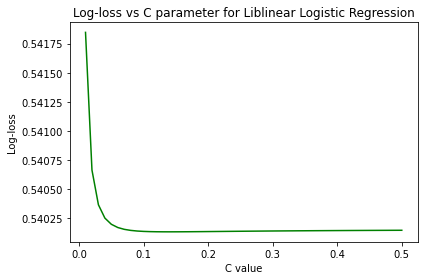

The best result is 0.540133469037271 where C= 0.14


In [106]:
#set up a for loop to iterate through multiple values for the C parameter
c_par = np.linspace(0.01,0.5,50) #set the C values that will be looped, 50 increments between C=0.01 and C=0.5

mean_log = np.zeros((len(c_par)))

for n in range(0,len(c_par)):
    LR_itr = LogisticRegression(C=c_par[n],solver='liblinear').fit(X_train,y_train)
    itr_prob = LR_itr.predict_proba(X_test)
    mean_log[n] = log_loss(y_test,itr_prob)
    
plt.plot(c_par,mean_log,'g')
plt.title('Log-loss vs C parameter for Liblinear Logistic Regression')
plt.ylabel('Log-loss')
plt.xlabel('C value')
plt.tight_layout()
plt.show()

print('The best result is', mean_log.min(), 'where C=', c_par[mean_log.argmin()])

In [109]:
#when C=0.14, the log-loss improves slightly from 0.54184 to 0.54013.. what do the other metrics look like with C=0.14

#train the model for C=0.14 and liblinear solver
LR_check = LogisticRegression(C=0.14, solver='liblinear').fit(X_train,y_train)
pred_check = LR_check.predict(X_test)
prob_check = LR_check.predict_proba(X_test)

#evaluation metrics
print('Jaccard similarity for Logistic Regression with C=0.14: ', jaccard_score(y_test, pred_check))
print('Logloss for Logistic Regression with C=0.14: ', log_loss(y_test, prob_check))
print('Test Accuracy for LR with C=0.14: ',metrics.accuracy_score(y_test,pred_check))
print(confusion_matrix(y_test,pred_check,labels=targetNames))
print(classification_report(y_test,pred_check))

Jaccard similarity for Logistic Regression with C=0.14:  0.49992937853107344
Logloss for Logistic Regression with C=0.14:  0.540133469037271
Test Accuracy for LR with C=0.14:  0.705277615916091
[[7079 4942]
 [2139 9866]]
              precision    recall  f1-score   support

           1       0.77      0.59      0.67     12021
           2       0.67      0.82      0.74     12005

    accuracy                           0.71     24026
   macro avg       0.72      0.71      0.70     24026
weighted avg       0.72      0.71      0.70     24026



In [110]:
#when comparing this to the original liblibear model (C=0.01), while the log-loss metric is improved, the jaccard
#and accuracy scores were slightly worse, and the confusion matrix had fewer correct predictions in both classes

#therefore, we'll keep the liblinear model with C=0.01 for final comparison with the other algorithms

LR_opt = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
lr_pred = LR_opt.predict(X_test)
lr_prob = LR_opt.predict_proba(X_test)

print('Test set accuracy: ',metrics.accuracy_score(y_test,lr_pred))
print('Train set accuracy: ',metrics.accuracy_score(y_train,LR_opt.predict(X_train)))

Test set accuracy:  0.7059851827187213
Train set accuracy:  0.705041760315214


#### Modeling summary:

After training models using KNN, Decision Tree, Support Vector Machine and Logistic Regression methods, the optimimum models from each type are:

- KNN: model w/ k=250 where a Test set accuracy of 0.70461 (simple accuracy) was achieved.
- Decision Tree: RandomForest model where Test set accuracy of 0.70507 was achieved.
- SVM: model with linear kernel function where Test set accuracy of 0.70257 was achieved.
- LR: model with liblinear solver and C parameter of 0.01 where Test set accuracy of 0.70599 was achieved.

For all of these models, the accuracy achieved on the Test dataset is extremely close, and precision and recall metrics observed in the classification report are also very close. There are some differences spotted between the respective confusion matrices, in terms of the balance between samples predicted to the two different classes. All of the models predicted more injury collisions than property collisions, by at least 4400. The Decision Tree and Logistic Regression models where even more skewed towards predicting injury collisions (predicting 5000+ more injury collisions than property collisions). Depending on further development of a model and the intended benefit/use of any potential deployment, a model's ability to avoid certain incorrect predictions (in either class) or have more balance between the two classes may become more important.

Lets look at a few more evaluation metrics and then summarize them for each model.

### 6.0 Model Evaluation

In this section we will evaluate the optimized model of each classification method using:

- Jaccard similarity
- F1-score
- Log-loss
- Area Under the ROC curve

In [111]:
#we have previously imported the jaccard, log-loss and f1 metrics, but there is one more we need to import
from sklearn.metrics import roc_auc_score

In [112]:
#the trained models and their predictions are above, but in order to properly use each of the listed metrics, probabilities
#for each test sample will need to be predicted for the KNN, Decision Tree and SVM models

#for reference, the respective models and predicted variables are commented below:

# KNN -- model: KNN_opt, predictions: knn_pred
# DT -- model: RDFT, predictions: DT_pred
# SVM -- model: SVM_opt, predictions: svm_pred
# LR -- model: LR_opt, predictions: lr_pred, probability predictions: lr_prob

#generate probability predictions for the KNN, Decision Tree and SVM models

knn_prob = KNN_opt.predict_proba(X_test)
DT_prob = RFDT.predict_proba(X_test)
svm_prob = SVM_opt.predict_proba(X_test)

In [116]:
#calculate simple accuracy for each model
knn_acc = metrics.accuracy_score(y_test,knn_pred)
dt_acc = metrics.accuracy_score(y_test,DT_pred)
svm_acc = metrics.accuracy_score(y_test,svm_pred)
lr_acc = metrics.accuracy_score(y_test,lr_pred)

#calculate jaccard similarity scores for each model
knn_jac = jaccard_score(y_test,knn_pred)
dt_jac = jaccard_score(y_test,DT_pred)
svm_jac = jaccard_score(y_test,svm_pred)
lr_jac = jaccard_score(y_test,lr_pred)

#calculate f1-scores for each model
knn_f1 = jaccard_score(y_test,knn_pred,average='weighted')
dt_f1 = jaccard_score(y_test,DT_pred,average='weighted')
svm_f1 = jaccard_score(y_test,svm_pred,average='weighted')
lr_f1 = jaccard_score(y_test,lr_pred,average='weighted')

#calculate log-loss for each model
knn_lgl = log_loss(y_test,knn_prob)
dt_lgl = log_loss(y_test,DT_prob)
svm_lgl = log_loss(y_test,svm_prob)
lr_lgl = log_loss(y_test,lr_prob)

#calculate area under ROC for each model
knn_roc_prob = [p[1] for p in knn_prob]
knn_roc = roc_auc_score(y_test,knn_roc_prob)

dt_roc_prob = [p[1] for p in DT_prob]
dt_roc = roc_auc_score(y_test,dt_roc_prob)

svm_roc_prob = [p[1] for p in svm_prob]
svm_roc = roc_auc_score(y_test,svm_roc_prob)

lr_roc_prob = [p[1] for p in lr_prob]
lr_roc = roc_auc_score(y_test,lr_roc_prob)


In [126]:
#compile table of results to dictionary
results = {'KNN': ['k=250',knn_acc,knn_jac,knn_f1,knn_lgl,knn_roc],
          'Decision Tree': ['Random Forest',dt_acc,dt_jac,dt_f1,dt_lgl,dt_roc],
          'SVM': ['linear kernel',svm_acc,svm_jac,svm_f1,svm_lgl,svm_roc],
          'Logistic Regression': ['liblinear, C=0.01',lr_acc,lr_jac,lr_f1,lr_lgl,lr_roc]}

#read dictionary to dataframe
results_df = pd.DataFrame.from_dict(results,orient='index')
results_df.reset_index(drop=False, inplace=True)
results_df.columns = ['Algorithm','Model feature','Accuracy','Jaccard','F1-score','Log-loss','AUROC']

#display results
results_df

,Algorithm,Model feature,Accuracy,Jaccard,F1-score,Log-loss,AUROC
0,KNN,k=250,0.704612,0.507870,0.541453,0.540904,0.786865
1,Decision Tree,Random Forest,0.705070,0.503503,0.541335,0.547774,0.788573
2,SVM,linear kernel,0.702572,0.506798,0.539207,0.605143,0.750791
3,Logistic Regression,"liblinear, C=0.01",0.705985,0.500636,0.541839,0.541847,0.790964


### Evaluation Summary:

The results are **_very_** similar for each of the different models. The Logistic Regression approach performed best for 3 of the 5 metrics: simple accuracy, F1 and AUROC, while the KNN algorithm was the best according to Jacard and Log-loss. Interestingly, despite performing best in 3 categories and second in another, the Logistic Regression model had the worst Jaccard similarity score of the 3 models.

Ultimately, the result are so similar that selecting a model might come down to its performance with respect to predicting against each classification. If being conservative - predicting fewer injury collisions is preferred - then the SVM or KNN models might be best, whereas the Logistic Regression and Decision Tree model might be preferable if higher sensitivity is required for predicting injury type collisions.